In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [22]:
torch.cuda.is_available()

True

In [23]:
torch.backends.cudnn.enabled

True

In [21]:
PATH = 'data/iMaterialist/'
sz=224

In [5]:
ls {PATH}

labels.gz                  test/          train_10k/      valid/
sample_submission.csv      test.json      train.json      validation.json
sample_submission.csv.zip  test.json.zip  train.json.zip  validation.json.zip


In [9]:
def get_1st(path): return glob(f'{path}/*.*')[0]

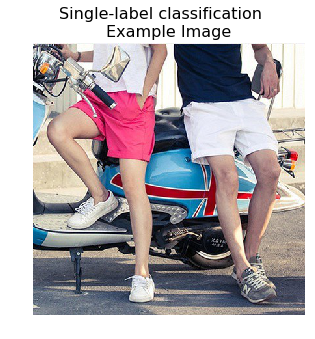

In [11]:
fn = get_1st(f'{PATH}train_10k')
plots_from_files([fn], titles=['Example Image'], maintitle="Single-label classification")

In [26]:
from fastai.metrics import f1
metrics = [f1]
f_model = resnet34

In [ ]:
tfms = tfms_from_model(f_model, sz)
data = ImageClassifierData.from_csv(PATH, 'train_10k', 'labels.csv', tfms=tfms, )

In [18]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [ ]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

In [20]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

1014544